For an analysis competition...
- EDA
- feature engineering
- adversarial validation
- feature importance
- one hot nan
- pseudolabel
- data augumentation


# Libraries

In [4]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer

# stats
from scipy import stats
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

libraries imported


# Load data

In [ ]:
!ls

In [5]:
# check path
datapath = "inputs/"
files = os.listdir(datapath)
print(files)

['.DS_Store', 'atma2020', 'house-prices-advanced-regression-techniques']


In [6]:
# datapath = "inputs/atma2020/"
datapath = datapath + files[1]
os.listdir(datapath)

['images.zip',
 '.DS_Store',
 'images',
 'test.csv',
 'user_log.csv',
 'atmacup3_sample_submission.csv',
 'poi.csv',
 'train.csv']

In [7]:
# import data
time0 = time.time()

datapath = "inputs/" + files[1] + "/"
train = pd.read_csv(datapath + 'train.csv')
test = pd.read_csv(datapath + 'test.csv')
pid = pd.read_csv(datapath + 'poi.csv')
userlog = pd.read_csv(datapath + 'user_log.csv')
submission = pd.read_csv(datapath + 'atmacup3_sample_submission.csv')

time1 = time.time()
print(time1 - time0, " seconds to load data")

0.5989718437194824  seconds to load data


In [9]:
# check train
print(train.shape)
train.head()

(6612, 4)


,target,imid,pid,session_id
0,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3
1,0,1,444114354,d2a0954800cdf92417061e02cfd765ad
2,0,2,353246021,5885fa648d1350c37dd46407979df21e
3,0,3,739812558,474cf9d584a81ad4f7b1f2c9d7e8d1ac
4,0,4,357087521,7d0df4c95c7f44b46eeda683b52cd04e


In [10]:
# check test
print(test.shape)
test.head()

(6799, 3)


,imid,pid,session_id
0,6612,353680133,7a55c13ff9b428c79edacd0f42ab6c94
1,6613,454530459,71636f0b8084af4a524cbf57c82b46b9
2,6614,339233638,19290fba480ed18ba1c1cc860727c9a9
3,6615,355685067,db85dc8a1770406c75e5ae82badd786a
4,6616,527126605,5e348ae0dd096b6921fa998664fa78bb


In [11]:
print(pid.shape)
pid.head()

(3435, 6)


,pid,latitude,longitude,radius,type,name
0,822762390,34.377265,39.487320,23,0,1
1,762688441,36.602066,43.709515,23,0,1
2,542865614,34.971339,45.478901,37,0,1
3,359227369,35.769068,46.751073,73,0,1
4,727831145,34.812505,42.471415,22,0,1


In [12]:
print(userlog.shape)
userlog.head()

(363087, 17)


,latitude,longitude,sysname,optout,lang,timezone,session_id,hour,minute,second,day_of_week,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6
0,35.674171,46.849018,iOS,0,ja-JP,Asia/Tokyo,307331f8b339e4bee9647cd0081fd7f6,15,22,16,5,3,1,14,6.0,5,112
1,35.793724,47.411649,Android,0,ja_JP,Asia/Tokyo,ef4702f1b992b76c1fdc7ce15df8768c,10,36,40,5,4,0,31,NaN,4,129
2,35.749878,46.675739,iOS,0,en-JP,Asia/Tokyo,42ac72ea64aad33de738111faa1ad393,20,22,46,5,3,1,14,2.0,5,113
3,33.590342,37.509837,Android,0,ja_JP,Asia/Tokyo,fe9911ad9db3e11ed1792f3ef54c58e8,13,33,57,3,4,0,40,NaN,1,103
4,42.995149,48.523041,Android,0,ja_JP,Asia/Tokyo,893b0f5baabf3671fdd1a62cd05f75cd,22,56,55,2,4,1,31,2.0,1,186


In [14]:
print(submission.shape)
submission.head()

(6799, 1)


,target
0,1.000000
1,0.916667
2,0.625000
3,0.791667
4,1.000000


# Userlog distance EDA

In [15]:
train_pid = train.merge(pid, how="left", on="pid")
test_pid = test.merge(pid, how="left", on="pid")
print(train_pid.shape)
train_pid.head()

(6612, 9)


,target,imid,pid,session_id,latitude,longitude,radius,type,name
0,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,36.320751,46.104755,25,2,0
1,0,1,444114354,d2a0954800cdf92417061e02cfd765ad,35.564913,46.744633,51,0,1
2,0,2,353246021,5885fa648d1350c37dd46407979df21e,35.693777,46.784288,189,0,1
3,0,3,739812558,474cf9d584a81ad4f7b1f2c9d7e8d1ac,33.744577,42.465361,25,0,1
4,0,4,357087521,7d0df4c95c7f44b46eeda683b52cd04e,35.545631,46.858787,181,0,3


In [16]:
userlog.head()

,latitude,longitude,sysname,optout,lang,timezone,session_id,hour,minute,second,day_of_week,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6
0,35.674171,46.849018,iOS,0,ja-JP,Asia/Tokyo,307331f8b339e4bee9647cd0081fd7f6,15,22,16,5,3,1,14,6.0,5,112
1,35.793724,47.411649,Android,0,ja_JP,Asia/Tokyo,ef4702f1b992b76c1fdc7ce15df8768c,10,36,40,5,4,0,31,NaN,4,129
2,35.749878,46.675739,iOS,0,en-JP,Asia/Tokyo,42ac72ea64aad33de738111faa1ad393,20,22,46,5,3,1,14,2.0,5,113
3,33.590342,37.509837,Android,0,ja_JP,Asia/Tokyo,fe9911ad9db3e11ed1792f3ef54c58e8,13,33,57,3,4,0,40,NaN,1,103
4,42.995149,48.523041,Android,0,ja_JP,Asia/Tokyo,893b0f5baabf3671fdd1a62cd05f75cd,22,56,55,2,4,1,31,2.0,1,186


In [60]:
example_session_id = "ff4fb3bcc5c51195faf3241807aa02fa"
train_pid.loc[train_pid["session_id"] == example_session_id, ["latitude", "longitude"]]

,latitude,longitude
5,35.174939,44.114999
186,35.140178,43.949223
299,35.167237,43.974969
529,35.169238,43.971680
1252,35.162840,44.076985
1673,35.160668,44.064010
1889,35.136646,44.053124
2008,35.169985,43.970376
2810,35.166897,44.035417
2815,35.167615,43.996665


In [61]:
userlog.loc[userlog["session_id"] == example_session_id, ["latitude", "longitude"]]

,latitude,longitude
10,35.169617,44.006870
27,35.158325,43.971989
300,35.170593,44.138920
2517,35.175232,43.971516
2950,35.165924,43.997288
3432,35.164429,43.975635
3653,35.190887,43.987675
3864,35.166748,43.995701
4621,35.174042,43.996418
4880,35.172455,43.997837


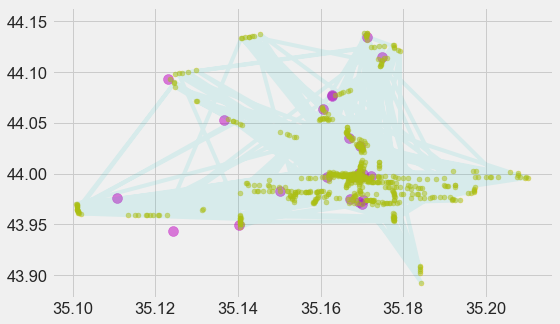

In [62]:
def user_shop_plot(df=train_pid, session_id=example_session_id):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    shop = df.loc[df["session_id"] ==session_id, ["latitude", "longitude", "radius"]].reset_index(drop=True, inplace=False)
    user = userlog.loc[userlog["session_id"] == session_id, ["latitude", "longitude"]].reset_index(drop=True, inplace=False)
    ax.scatter(shop["latitude"].values, shop["longitude"].values, color="m", alpha=0.5, s=100)
    ax.scatter(user["latitude"].values, user["longitude"].values, color="y", alpha=0.5, s=25)
    ax.plot(user["latitude"].values, user["longitude"].values, color="c", alpha=0.1)
    for s in np.arange(len(shop)):
        x = shop.loc[s, "latitude"]
        y = shop.loc[s, "longitude"]
        r = shop.loc[s, "radius"]
        plt.Circle((x, y), r, color='r', alpha=0.5)
    
user_shop_plot(train_pid, "ff4fb3bcc5c51195faf3241807aa02fa")

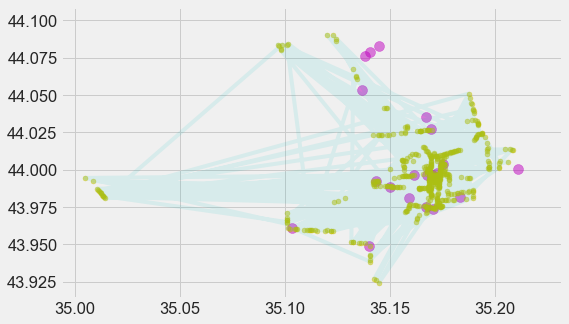

In [63]:
user_shop_plot(train_pid, session_id="71c8d7611e8f48d5d46b5d5e89f716a1")

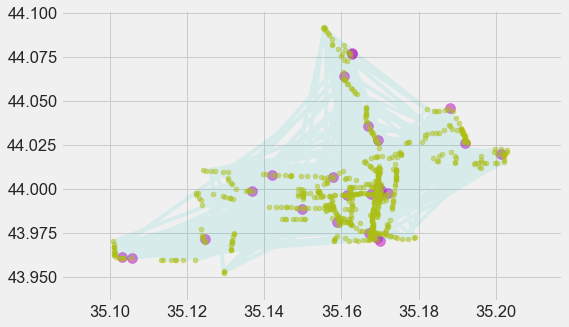

In [64]:
user_shop_plot(test_pid, "bc58e9143f8c3a636f51c89b11f2214d")

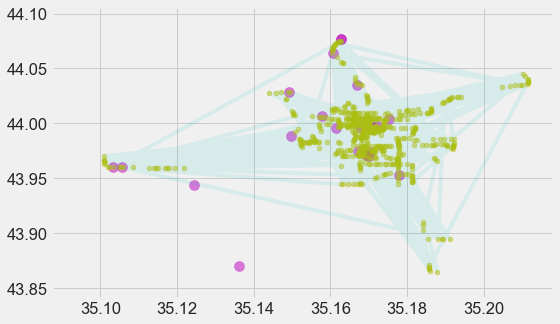

In [65]:
user_shop_plot(test_pid, "25f617d3d0280331c1e2178d744b9ffc")

# Merge table

In [66]:
train.dtypes

target         int64
imid           int64
pid            int64
session_id    object
dtype: object

In [67]:
pid.dtypes

pid            int64
latitude     float64
longitude    float64
radius         int64
type           int64
name           int64
dtype: object

In [68]:
userlog.dtypes

latitude         float64
longitude        float64
sysname           object
optout             int64
lang              object
timezone          object
session_id        object
hour               int64
minute             int64
second             int64
day_of_week        int64
categorical_1      int64
categorical_2      int64
categorical_3      int64
categorical_4    float64
categorical_5      int64
categorical_6      int64
dtype: object

In [69]:
def compute_distance(x0, x1, y0, y1, n):
    return (np.abs(x0 - x1) ** n + np.abs(y0 - y1) ** n) ** (1 /n)

def distance_matrix(df, userlog):
    sid = df["session_id"].unique()
    print(sid)
    new_userlog = pd.DataFrame()
    for s in sid:
        print(s)
        user = userlog.loc[userlog["session_id"] == s, :].reset_index(drop=True, inplace=False)
        shop = df.loc[df["session_id"] == s, :].reset_index(drop=True, inplace=False)
        print(shop.columns.values)
        d_mat = np.zeros((len(user), len(shop)))
        for u in np.arange(len(user)):
            user_x = user.loc[u, "latitude"]
            user_y = user.loc[u, "longitude"]
            for h in np.arange(len(shop)):
                shop_x = shop.loc[h, "shop_latitude"]
                shop_y = shop.loc[h, "shop_longitude"]
                d = compute_distance(user_x, user_y, shop_x, shop_y, 2)
                d_mat[u, h] = d
            d = np.min(d_mat, axis=1)
            user = user.loc[d < 0.2, :]
            new_userlog = pd.concat([new_userlog, user], ignore_index=True)

        return new_userlog
    
def merge_tables(train, test, pid, userlog):
    # id
    train["id"] = train["session_id"].astype(str) + "_" + train["pid"].astype(str) + "_" + np.arange(len(train)).astype(str)
    test["id"] = test["session_id"].astype(str) + "_" + test["pid"].astype(str) + "_" + np.arange(len(test)).astype(str)
    
    # rename
    pid = pid.rename(columns={"latitude": "shop_latitude", "longitude": "shop_longitude"})
    
    # merge with pid
    train = train.merge(pid, how="left", on="pid")
    test = test.merge(pid, how="left", on="pid")
    
#     # merge with userlog    
#     new_userlog_train = distance_matrix(train, userlog)
#     new_userlog_test = distance_matrix(test, userlog)

    # mean latitude, longitude
    sid = userlog["session_id"].unique()
    df = userlog.groupby("session_id")[["latitude", "longitude"]].agg("mean")
    userlog = userlog.merge(df, how="left", on="session_id", suffixes=("", "_mean"))
    
    train = train.merge(userlog, how="left", on="session_id")
    test = test.merge(userlog, how="left", on="session_id")

    return train, test

full_train, full_test = merge_tables(train, test, pid, userlog)
# d = merge_tables(train, test, pid, userlog)

In [70]:
print(full_train.shape)
full_train.head()

(613978, 28)


,target,imid,pid,session_id,id,shop_latitude,shop_longitude,radius,type,name,...,second,day_of_week,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,latitude_mean,longitude_mean
0,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,32,4,3,2,30,2.0,5,65,36.327215,46.105079
1,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,15,4,3,0,30,2.0,5,65,36.327215,46.105079
2,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,26,4,3,1,30,2.0,5,65,36.327215,46.105079
3,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,32,4,3,2,30,2.0,5,142,36.327215,46.105079
4,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,56,4,3,2,30,2.0,5,65,36.327215,46.105079


In [71]:
full_test.shape

(616766, 27)

In [72]:
full_train.columns.values

array(['target', 'imid', 'pid', 'session_id', 'id', 'shop_latitude',
       'shop_longitude', 'radius', 'type', 'name', 'latitude',
       'longitude', 'sysname', 'optout', 'lang', 'timezone', 'hour',
       'minute', 'second', 'day_of_week', 'categorical_1',
       'categorical_2', 'categorical_3', 'categorical_4', 'categorical_5',
       'categorical_6', 'latitude_mean', 'longitude_mean'], dtype=object)

In [73]:
print(full_train.shape)
full_train.head()

(613978, 28)


,target,imid,pid,session_id,id,shop_latitude,shop_longitude,radius,type,name,...,second,day_of_week,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,latitude_mean,longitude_mean
0,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,32,4,3,2,30,2.0,5,65,36.327215,46.105079
1,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,15,4,3,0,30,2.0,5,65,36.327215,46.105079
2,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,26,4,3,1,30,2.0,5,65,36.327215,46.105079
3,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,32,4,3,2,30,2.0,5,142,36.327215,46.105079
4,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,56,4,3,2,30,2.0,5,65,36.327215,46.105079


shop lat std 0.017928262463364007
shop lon std 0.05238783460986169


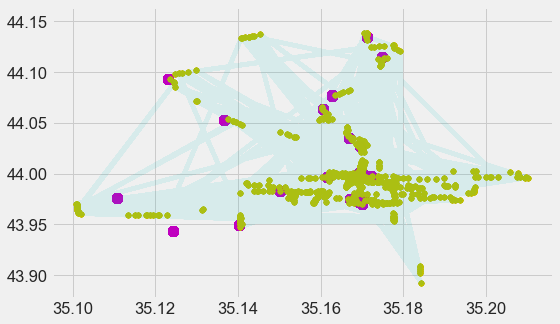

In [75]:
def posplot(full_train, session_id):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.scatter(full_train.loc[full_train["session_id"] == session_id, "shop_latitude"].values, 
               full_train.loc[full_train["session_id"] == session_id, "shop_longitude"].values, 
               color="m", alpha=0.5, s=100)
    ax.scatter(full_train.loc[full_train["session_id"] == session_id, "latitude"].values, 
               full_train.loc[full_train["session_id"] == session_id,"longitude"].values,
               color="y", alpha=0.5, s=25)
    ax.plot(full_train.loc[full_train["session_id"] == session_id,"latitude"].values, 
            full_train.loc[full_train["session_id"] == session_id,"longitude"].values, color="c", alpha=0.1)
    print("shop lat std", full_train.loc[full_train["session_id"] == session_id, "shop_latitude"].std())
    print("shop lon std", full_train.loc[full_train["session_id"] == session_id, "shop_longitude"].std())
posplot(full_train, "ff4fb3bcc5c51195faf3241807aa02fa")

shop lat std 0.02188664707355495
shop lon std 0.03806788384575262


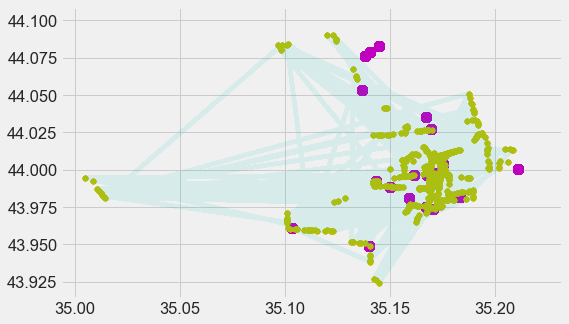

In [76]:
posplot(full_train, "71c8d7611e8f48d5d46b5d5e89f716a1")

# feature engineering
- shopとuserの距離（n乘）
- radiusとの差をとって，店の端っこまでの距離
- 中に入っているかのbinary
- 最後にいた店からの距離
- langの-と_を統一．jaを統一
- day of weekのsin cos？　週末フラグ

In [95]:
lang_mapper = {"ja-JP": "jp", "ja_JP": "jp", "en-JP": "en", "ja": "jp", "es-PE": "es", 
              "ja-US": "en", "ja-IE": "ie", "ja-CN": "cn", "en-US": "en", "ja-IS": "ls"}

def compute_distance(x0, x1, y0, y1, n):
    return (np.abs(x0 - x1) ** n + np.abs(y0 - y1) ** n) ** (1 /n)

def fe(full_train, full_test):
    for n in np.arange(1, 5, 0.5):
        # shopとuserの距離（n乘）
        full_train["user_shop_" + str(n)] = compute_distance(full_train["latitude"].values, full_train["shop_latitude"].values,
                                                       full_train["longitude"].values, full_train["shop_longitude"].values, n)
        full_test["user_shop_" + str(n)] = compute_distance(full_test["latitude"].values, full_test["shop_latitude"].values,
                                                       full_test["longitude"].values, full_test["shop_longitude"].values, n)
        
        # shopとuser重心の距離（n乘）
        full_train["usermean_shop_" + str(n)] = compute_distance(full_train["latitude_mean"].values, full_train["shop_latitude"].values,
                                                       full_train["longitude_mean"].values, full_train["shop_longitude"].values, n)
        full_test["usermean_shop_" + str(n)] = compute_distance(full_test["latitude_mean"].values, full_test["shop_latitude"].values,
                                                       full_test["longitude_mean"].values, full_test["shop_longitude"].values, n)
        
        # 中に入っているかのbinary
        full_train["is_inside_" + str(n)] = 1 * (full_train["user_shop_" + str(n)] < full_train["radius"])
        full_test["is_inside_" + str(n)] = 1 * (full_test["user_shop_" + str(n)] < full_test["radius"])
    
        # radiusとの差をとって，店の端っこまでの距離
        full_train["to_edge_" + str(n)] = full_train["user_shop_" + str(n)] / full_train["radius"]
        full_test["to_edge_" + str(n)] = full_test["user_shop_" + str(n)] / full_test["radius"]

     # 最後にいた店からの距離 ???
    
    # langの-と_を統一．jaを統一
    full_train["lang"] = full_train["lang"].map(lang_mapper)
    full_test["lang"] = full_test["lang"].map(lang_mapper)
    
    return full_train, full_test

# remove outliers
def remove_outliers(full_train, full_test):
    full_train[""]


In [96]:
full_train, full_test = fe(full_train, full_test)

In [97]:
full_train.head()

,target,imid,pid,session_id,id,shop_latitude,shop_longitude,radius,type,name,...,is_inside_3.5,to_edge_3.5,user_shop_4.0,usermean_shop_4.0,is_inside_4.0,to_edge_4.0,user_shop_4.5,usermean_shop_4.5,is_inside_4.5,to_edge_4.5
0,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,1,-24.998730,0.001268,0.006464,1,-24.998732,0.001267,0.006464,1,-24.998733
1,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,1,-24.996445,0.003555,0.006464,1,-24.996445,0.003555,0.006464,1,-24.996445
2,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,1,-24.998077,0.001922,0.006464,1,-24.998078,0.001922,0.006464,1,-24.998078
3,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,1,-24.994714,0.005275,0.006464,1,-24.994725,0.005269,0.006464,1,-24.994731
4,0,0,273201241,d552ce680cc1b10c9dc7aeb96a98b9f3,d552ce680cc1b10c9dc7aeb96a98b9f3_273201241_0,36.320751,46.104755,25,2,0,...,1,-24.998211,0.001787,0.006464,1,-24.998213,0.001786,0.006464,1,-24.998214


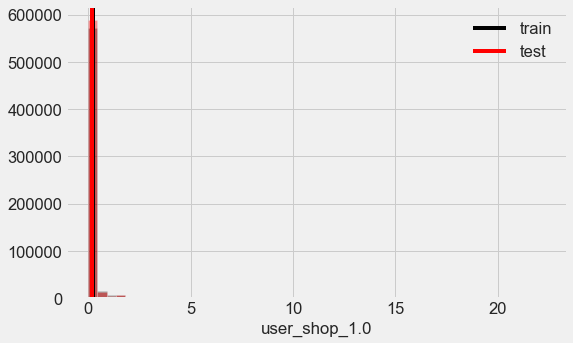

In [98]:
plot_hist(full_train, full_test, "user_shop_1.0")

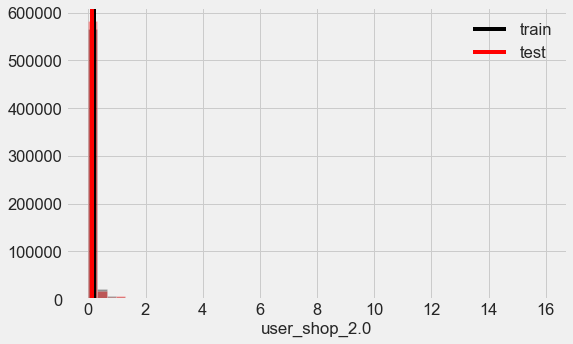

In [99]:
plot_hist(full_train, full_test, "user_shop_2.0")

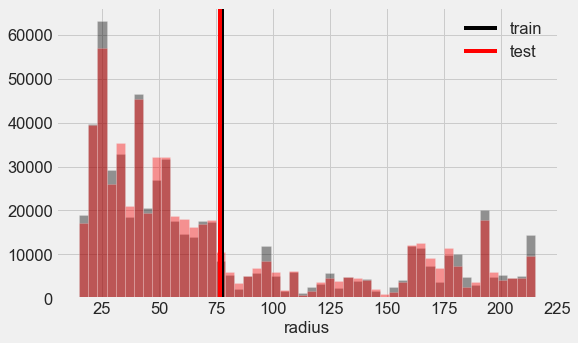

In [100]:
plot_hist(full_train, full_test, "radius")

In [89]:
# full_train.to_csv("features/full_train.csv", index=False)
# full_test.to_csv("features/full_train.csv", index=False)

# agg

In [90]:
full_train["id"].nunique()

6612

In [92]:
full_test["id"].head()

0    7a55c13ff9b428c79edacd0f42ab6c94_353680133_0
1    7a55c13ff9b428c79edacd0f42ab6c94_353680133_0
2    7a55c13ff9b428c79edacd0f42ab6c94_353680133_0
3    7a55c13ff9b428c79edacd0f42ab6c94_353680133_0
4    7a55c13ff9b428c79edacd0f42ab6c94_353680133_0
Name: id, dtype: object

In [93]:
print(full_train.shape)
full_train.columns.values

(613978, 60)


array(['target', 'imid', 'pid', 'session_id', 'id', 'shop_latitude',
       'shop_longitude', 'radius', 'type', 'name', 'latitude',
       'longitude', 'sysname', 'optout', 'lang', 'timezone', 'hour',
       'minute', 'second', 'day_of_week', 'categorical_1',
       'categorical_2', 'categorical_3', 'categorical_4', 'categorical_5',
       'categorical_6', 'latitude_mean', 'longitude_mean',
       'user_shop_1.0', 'usermean_shop_1.0', 'is_inside_1.0',
       'to_edge_1.0', 'user_shop_1.5', 'usermean_shop_1.5',
       'is_inside_1.5', 'to_edge_1.5', 'user_shop_2.0',
       'usermean_shop_2.0', 'is_inside_2.0', 'to_edge_2.0',
       'user_shop_2.5', 'usermean_shop_2.5', 'is_inside_2.5',
       'to_edge_2.5', 'user_shop_3.0', 'usermean_shop_3.0',
       'is_inside_3.0', 'to_edge_3.0', 'user_shop_3.5',
       'usermean_shop_3.5', 'is_inside_3.5', 'to_edge_3.5',
       'user_shop_4.0', 'usermean_shop_4.0', 'is_inside_4.0',
       'to_edge_4.0', 'user_shop_4.5', 'usermean_shop_4.5',
       '

In [ ]:
def aggregator(full_train, full_test):
    # initialize
    reduce_train = pd.DataFrame()
    reduce_test = pd.DataFrame()
    reduce_train["id"] = full_train["id"].unique()
    reduce_test["id"] = full_test["id"].unique()
    
    # agg
    full_train["

In [ ]:
stop

# EDA

## target

In [86]:
# target
target = full_train.columns.values[~np.isin(full_train.columns.values, full_test.columns.values)][0]
print(target)

target


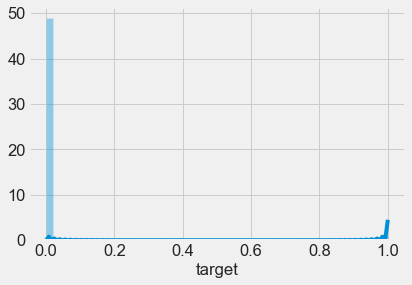

In [87]:
# target histogram
sns.distplot(full_train[target])

In [ ]:
full_train[target].value_counts()

## Missing values

In [ ]:
# msno.matrix(df=full_train, figsize=(16, 14), color=(0.5,0,0))

In [ ]:
# msno.matrix(df=test, figsize=(16, 14), color=(0.3,0,0))

In [ ]:
# msno.matrix(df=pid, figsize=(16, 14), color=(0.3,0,0))

In [ ]:
# msno.matrix(df=userlog, figsize=(16, 14), color=(0.3,0,0))

# Features

In [ ]:
# remove target from training features
features = full_test.columns.values.tolist()
print(len(features))
print(features)

In [ ]:
full_train["shop_latitude"].head()

In [ ]:
chk = column_checker(full_train, full_test, features)
chk

In [ ]:
# histogram for a dense feature
plot_hist(full_train, full_test, "shop_latitude")

In [ ]:
# histogram for a dense feature
plot_hist(full_train, full_test, "shop_longitude")

In [ ]:
# histogram for a dense feature
plot_hist(full_train, full_test, "radius")

In [ ]:
full_train["optout"].value_counts()

In [ ]:
# count plot for a categorical feature
plot_count(full_train, full_test, "sysname")

In [ ]:
# count plot for a categorical feature
plot_count(full_train, full_test, "type")

In [ ]:
# count plot for a categorical feature
plot_count(full_train, full_test, "name")

In [ ]:
full_train.groupby(["type", "name"])["target"].agg("count")

In [ ]:
full_test.groupby(["type", "name"])["radius"].agg("count")

In [ ]:
# venn
plot_venn(full_train, full_test, "session_id")

In [ ]:

plot_venn(full_train, full_test, "pid")

In [ ]:
plot_count(full_train, full_test, "timezone")

In [ ]:
full_train["timezone"].value_counts()

In [ ]:
plot_count(full_train, full_test, "lang")

In [ ]:
userlog["lang"].value_counts()

In [ ]:
plot_count(full_train, full_test, "day_of_week")

In [ ]:
plot_count(full_train, full_test, "categorical_1")

In [ ]:
plot_count(full_train, full_test, "categorical_2")

In [ ]:
plot_count(full_train, full_test, "categorical_3")

In [ ]:
full_train["categorical_3"].nunique()

In [ ]:
full_test["categorical_3"].nunique()

In [ ]:
plot_venn(full_train, full_test, "categorical_3")

In [ ]:
plot_count(full_train, full_test, "categorical_4")

In [ ]:
plot_count(full_train, full_test, "categorical_5")

In [ ]:
plot_count(full_train, full_test, "categorical_6")

In [ ]:
full_train["categorical_6"].nunique()

In [ ]:
full_test["categorical_6"].nunique()

In [ ]:
plot_count(full_train, full_test, "hour")

In [ ]:
plot_count(full_train, full_test, "minute")

## Feature Selection

### Categorical variables

In [ ]:
# remove categorical variables which do not match btw. train & test
# categoricals = chk.loc[(chk["is_categorical"] == 1) & (chk["overlap"] == 1), "features"].values.tolist()

categoricals = ["sysname", "lang"]
print(len(categoricals))
print(categoricals)

# label encoding
for c in categoricals:
    le = LabelEncoder()
    le.fit(full_train[c].fillna("NA"))
    full_train[c] = le.transform(full_train[c].fillna("NA"))
    full_test[c] = le.transform(full_test[c].fillna("NA"))
    
print(len(categoricals))
print(categoricals)

In [ ]:
full_train.columns.values

In [ ]:
categoricals = categoricals + ["type", "name", "optout","lang", "hour", ]

### Dense variables

In [ ]:
dense_features = chk.loc[(chk["is_categorical"] == 0), "features"].values.tolist()
print(len(dense_features))
print(dense_features)

In [ ]:
# preprocess
df = pd.concat([train, test], ignore_index=True)

# nan one hot
df, isnan_features = nan2onehot(df, dense_features)
        
# outlier remover
df = clipper(df, dense_features)
    
# to normal dist
# df = to_normal(df, dense_features)

categoricals = categoricals + isnan_features
# back to train, test
train = df.loc[:train.shape[0], :].reset_index(drop=True, inplace=False)
test = df.loc[train.shape[0]:, :].reset_index(drop=True, inplace=False)

In [ ]:
features = dense_features + categoricals
print(train[features].shape)
train[features].head()

In [ ]:
print(test[features].shape)
test[features].head()

# Feature importance

In [ ]:
# LGB params
lgb_params = {"num_leaves": 45,
    "boosting_type": 'gbdt',
    "objective": 'regression',
    "metric": 'rmse',
    "max_depth": 7,
    "min_child_weight": 4,
    "feature_fraction": 0.52,
    "bagging_fraction": 0.97,
    "bagging_freq": 2,
    "min_child_samples": 27,
    "lambda_l1": 2.80368645398501e-06,
    "lambda_l2": 8.920589790760632e-06,
    "learning_rate": 0.07,
    "early_stopping_rounds": 300
    }

In [ ]:
# LGB model
def fit_lgb(x_train, x_val, y_train, y_val, features, categoricals):
    verbosity = 100
    train_set = lgb.Dataset(x_train[features], y_train, categorical_feature=categoricals)
    val_set = lgb.Dataset(x_val[features], y_val, categorical_feature=categoricals)
    lgb_model = lgb.train(lgb_params, train_set, 1000, valid_sets=[train_set, val_set], verbose_eval=verbosity)
    fi = lgb_model.feature_importance(importance_type="gain")        
    return fi

# feature importance stored in data frame
def fi2df(fi, features=features):
    ranking = np.argsort(-fi)
    fi_df = pd.DataFrame()
    fi_df["features"] = np.array(features)[ranking]
    fi_df["importance_mean"] = fi[ranking]
    return fi_df

def plot_feature_importance(fi_df, rank_range=[1, 50]):
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 30))
    sns.barplot(x=fi_df.loc[:rank_range[1], "importance_mean"].values, y=fi_df.loc[:rank_range[1], "features"].values, orient='h', ax=ax)
    ax.set_xlabel("feature importance")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 

In [ ]:
kf = KFold(n_splits=3, random_state=1220, shuffle=True)
for fold, (tr_idx, va_idx) in enumerate(kf.split(train)):
    if fold == 0:
        x_train, x_val = train.loc[tr_idx, features], train.loc[va_idx, features]
        y_train, y_val = train.loc[tr_idx, target], train.loc[va_idx, target]

In [ ]:
x_train.head()

In [ ]:
# fit LGB
fi = fit_lgb(x_train, x_val, y_train, y_val, features, categoricals)

In [ ]:
fi_df = fi2df(fi, features)
plot_feature_importance(fi_df, rank_range=[1, 50])